In [1]:
%matplotlib inline

# Analyze MERFISH Mouse Cortex data
This tutorial shows how to apply Bering to MERFISH data.

MERFISH mouse cortex data {cite}`zhang2021spatially`, which contains transcripts which were segmented vs. unsegmented in the original paper. Coordinates (x, y, z (optional)) and gene names are required for all nodes. For segmented transcripts, we additionally require information about segmented cell id and labels.

### Import packages & data

In [2]:
import random
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 

import Bering as br

In [3]:
mpl.rcParams['figure.figsize'] = [3.5, 3.5]

In [4]:
# load data
df_spots_all = br.datasets.merfish_cortex_zhang()
df_spots_seg = df_spots_all[df_spots_all['labels'] != 'background'] # foreground nodes
df_spots_unseg = df_spots_all[df_spots_all['labels'] == 'background'] # background nodes
df_spots_seg.head()

,x,y,z,features,segmented,labels
5163158,-4146.0044,1027.1519,0.0,Aqp4,187427829321727974677294895804085147126,VLMC
5163175,-4147.0884,1028.8763,0.0,Igf2,187427829321727974677294895804085147126,VLMC
5163190,-4145.6426,1028.3645,0.0,Nr2f2,187427829321727974677294895804085147126,VLMC
5163198,-4143.3530,1025.8699,0.0,Rgs6,187427829321727974677294895804085147126,VLMC
5163200,-4145.2314,1026.4473,0.0,Serpinf1,187427829321727974677294895804085147126,VLMC


In [5]:
df_spots_unseg.head() # visualize unsegmented data

,x,y,z,features,segmented,labels
5163155,-4116.2620,918.22800,0.0,Aqp4,-1,background
5163156,-4145.6465,931.03687,0.0,Aqp4,-1,background
5163157,-4192.2363,1023.08344,0.0,Aqp4,-1,background
5163159,-4193.5073,1029.53480,0.0,Aqp4,-1,background
5163160,-4092.1545,1017.06165,0.0,Bgn,-1,background


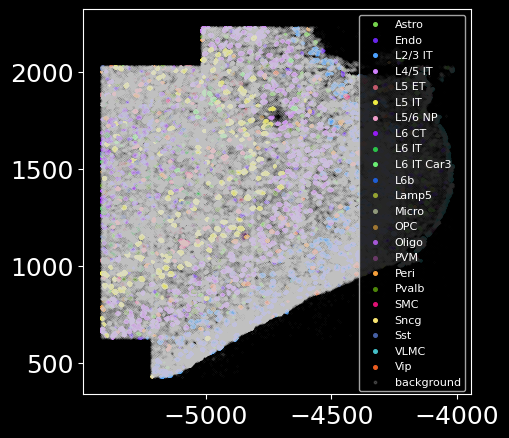

In [6]:
# visualize segmented and unsegmented data
br.pl.Plot_Spots(df_spots_seg = df_spots_seg, df_spots_unseg = df_spots_unseg)

### Create Bering object

In [7]:
img = None; channels = None # image-free segmentation in this case
bg = br.BrGraph(
    df_spots_seg, df_spots_unseg, img, channels,
)
bg

In [8]:
bg.segmented.head() # summary of cells

,cx,cy,cz,dx,dy,dz,d,labels
segmented,,,,,,,,
0,-4147.2183,1029.63480,3.0,9.2470,6.2306,6.0,9.2470,VLMC
1,-4140.8835,1121.99090,4.5,16.9153,7.4033,7.5,16.9153,SMC
2,-4139.7197,1130.35130,6.0,29.8024,23.6521,7.5,29.8024,VLMC
3,-4158.9525,1081.01685,4.5,19.1810,12.3783,7.5,19.1810,VLMC
4,-4153.4095,1092.16530,4.5,11.9056,11.9655,7.5,11.9655,VLMC


### Create training data

In [9]:
# Build graphs for GCN training purpose
br.graphs.BuildWindowGraphs(
    bg, 
    n_cells_perClass = 30, 
    window_width = 50.0, 
    window_height = 50.0, 
    n_neighbors = 30, 
    use_unsegmented_ratio = 0.5, # use 50% of unsegmented spots to avoid learning too much knwoledge from unsegmented spots / noises
)

In [10]:
br.graphs.CreateData(
    bg, 
    batch_size = 16, 
    training_ratio = 0.8, 
)

### Training

Training node classifier:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████ | 99/100 [00:39<00:00,  2.71it/s]

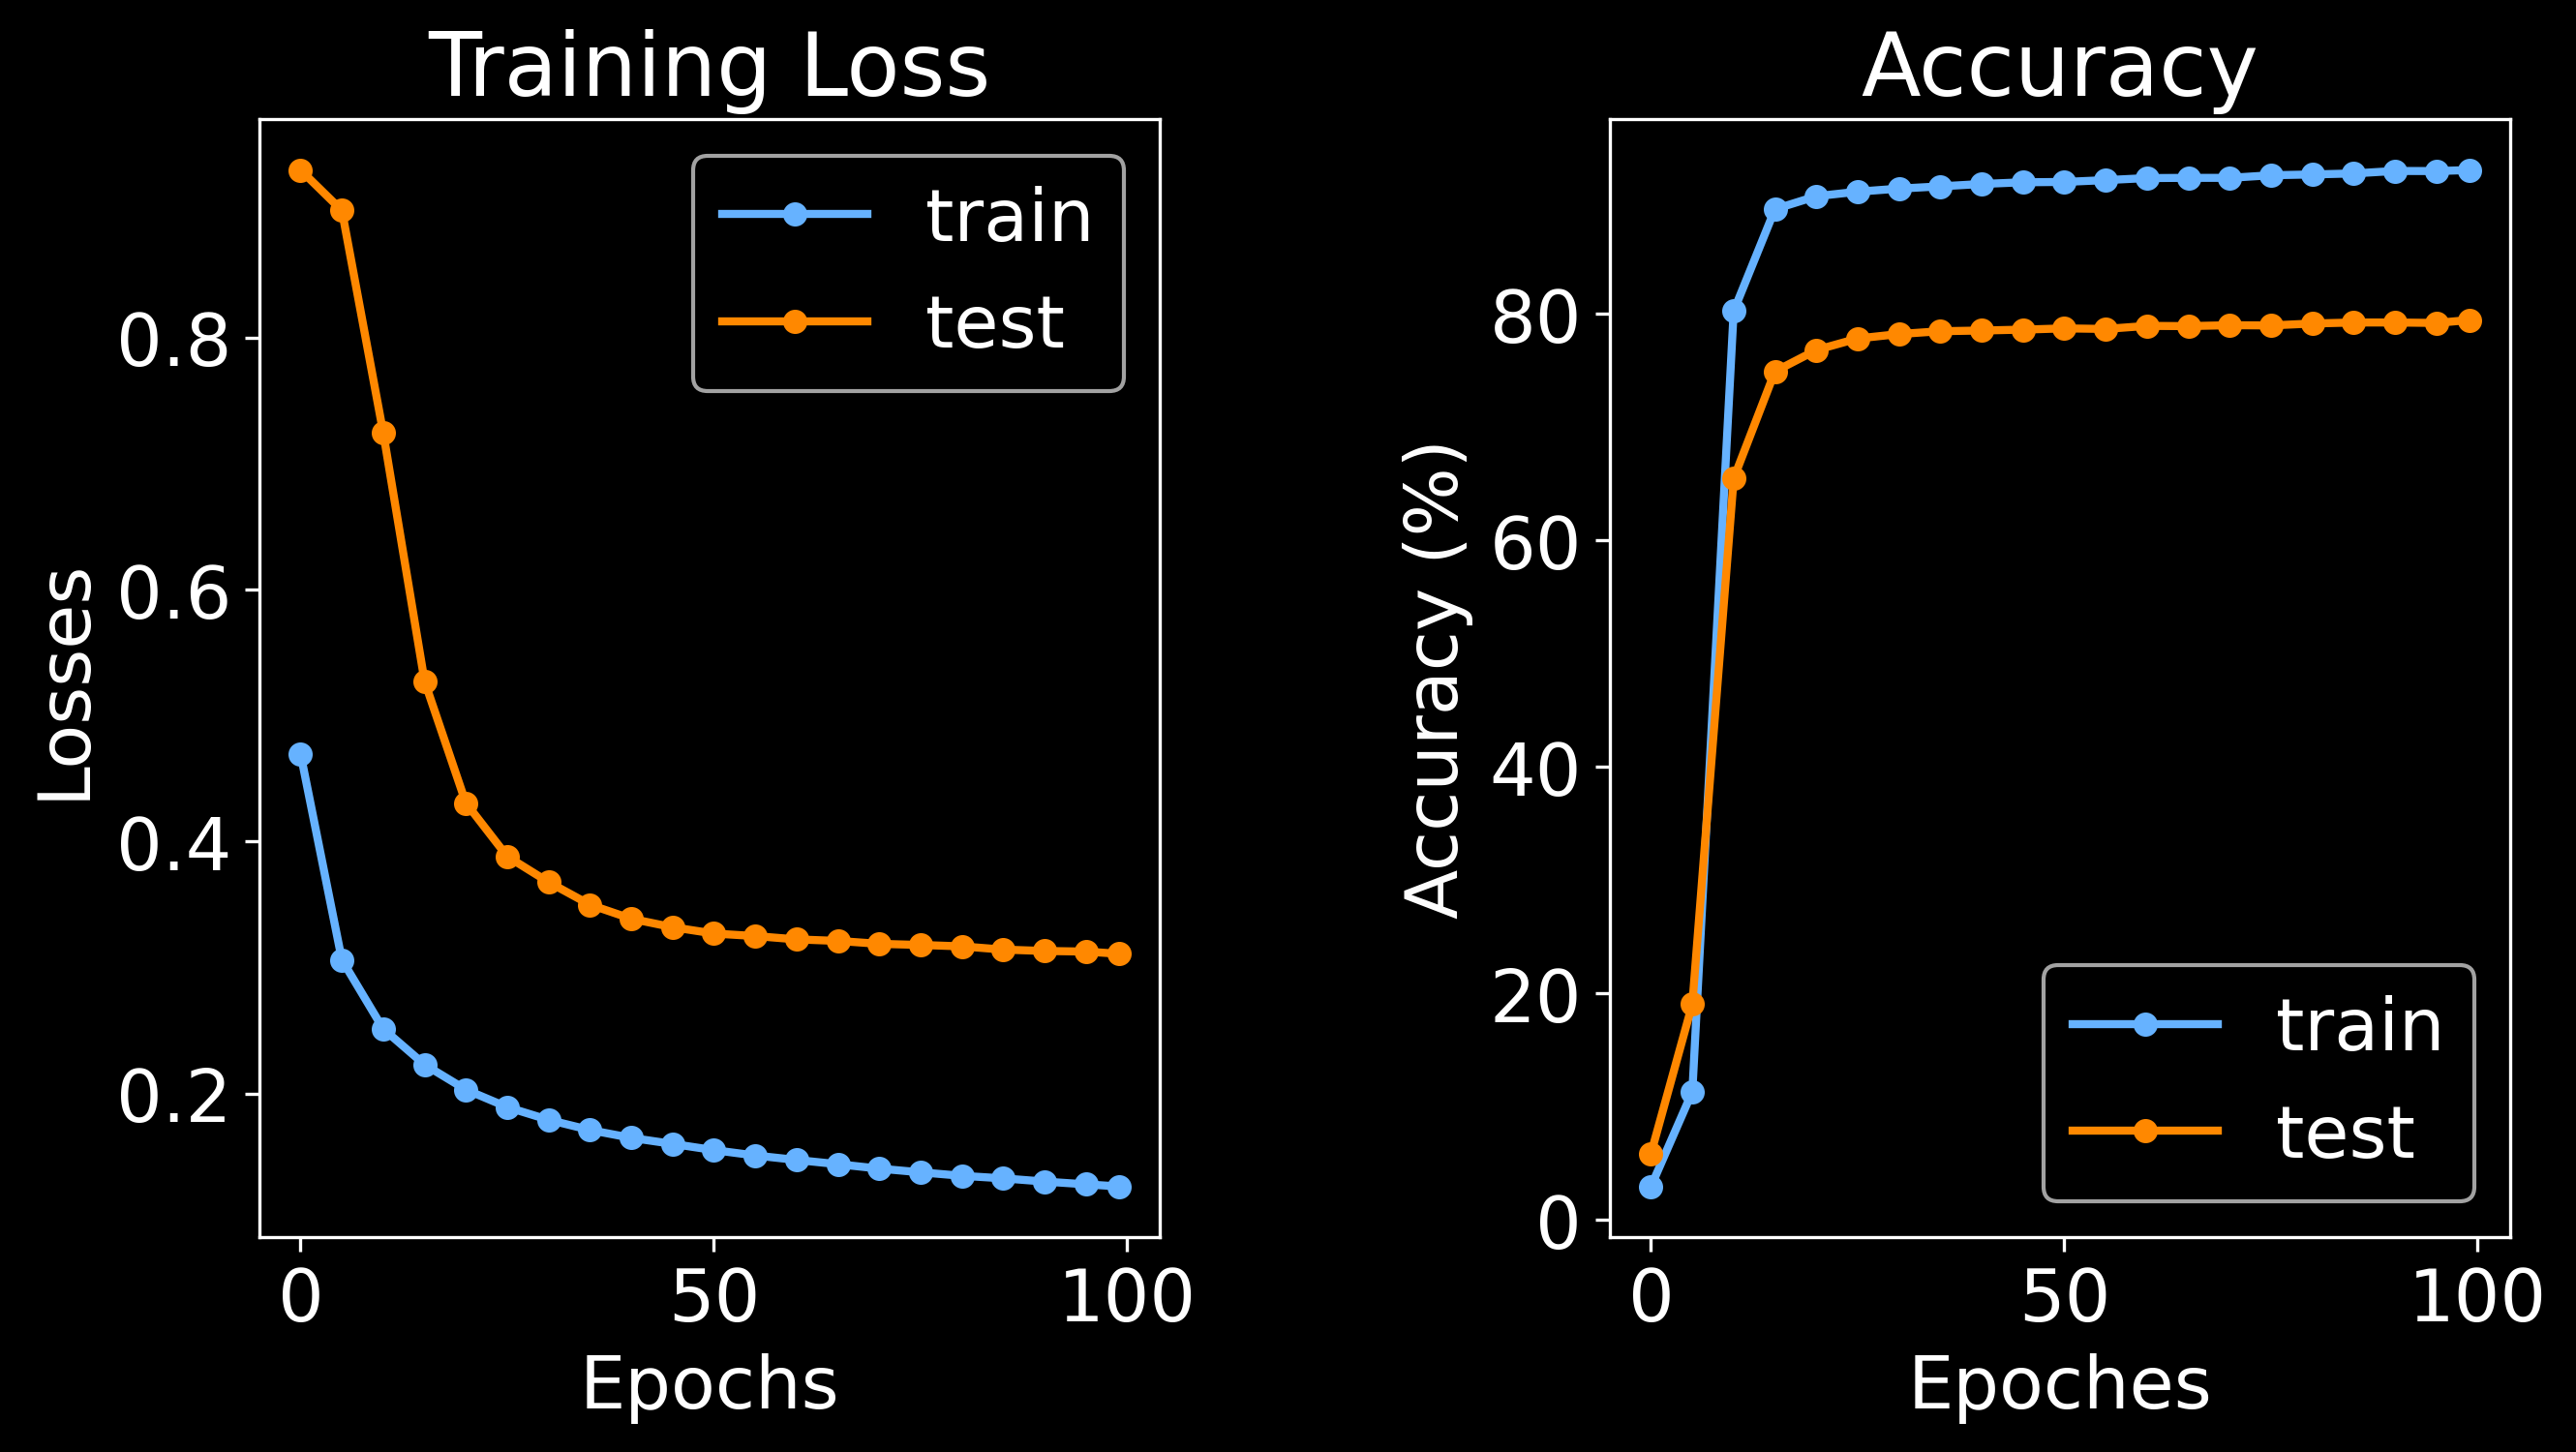

Training edge classifier:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████  | 49/50 [00:22<00:00,  3.65it/s]

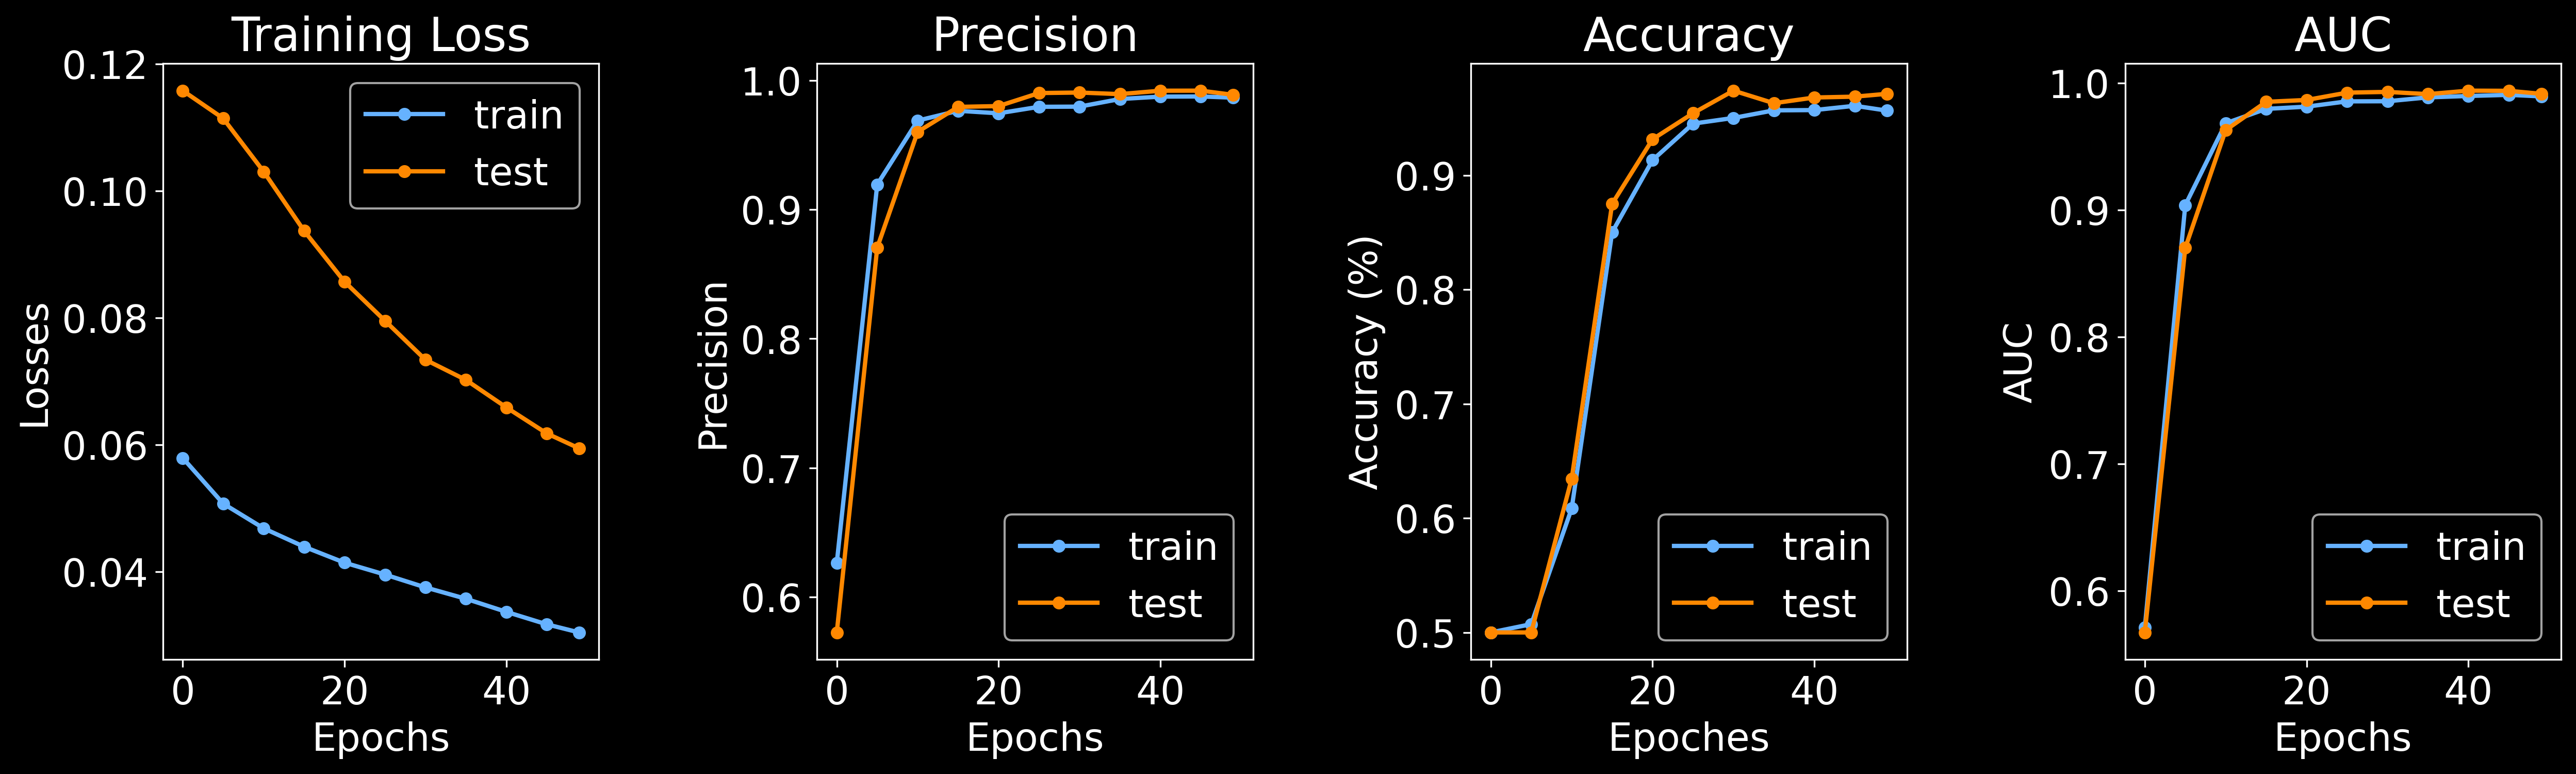

Training edge classifier: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.07it/s]


In [11]:
br.train.Training(
    bg,
    node_gcnq_hidden_dims = [512, 256, 128, 128, 64, 64, 32, 16],
    node_foreground_weight = 2.0,
    node_background_weight = 1.0,
    edge_rbf_start = 0,
    edge_rbf_stop = 64,
    edge_rbf_n_kernels = 32,
    node_epoches = 100,
)

In [12]:
# save the trained model
import pickle
with open('merfish_cortex_zhang.pkl', 'wb') as f:
    pickle.dump(bg, f)

### Visualizing model

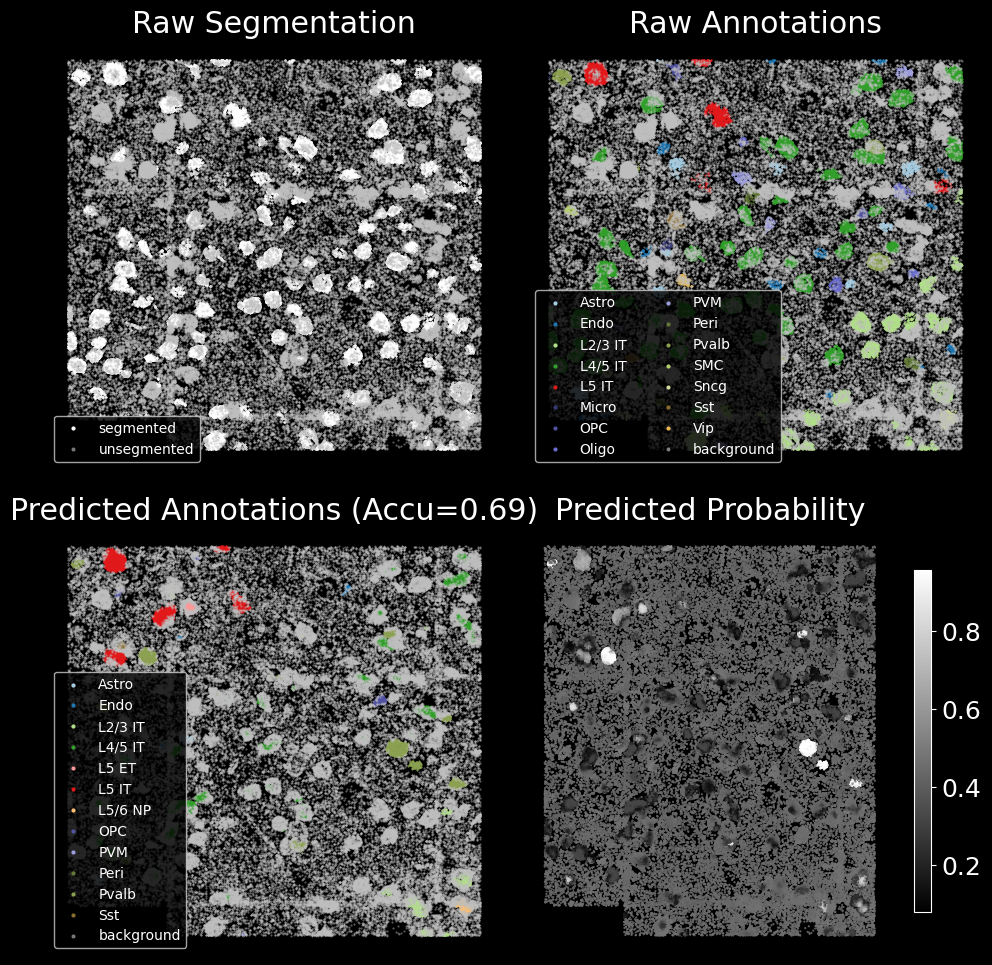

In [13]:
# randomly select a cell
random_cell = cells = random.sample(bg.segmented.index.values.tolist(), 1)[0]

# plot node classification
_ = br.pl.Plot_Classification(
    bg, 
    cell_name = random_cell,
    n_neighbors = 30, 
    zoomout_scale = 12,
)

Plotting segmentation for the region around cell 285


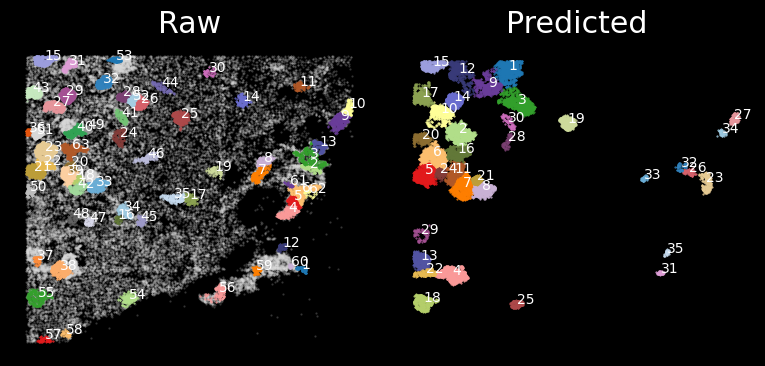

In [14]:
# plot cell segmentation (original and predicted cells are on left and right, respectively)
random_cells = cells = random.sample(bg.segmented.index.values.tolist(), 1)[:3]
for random_cell in random_cells:
    print(f'Plotting segmentation for the region around cell {random_cell}')
    br.pl.Plot_Segmentation(
        bg, 
        cell_name = random_cell,
        n_neighbors = 30, 
        zoomout_scale = 12,
        use_image = False,
        pos_thresh = 0.7,
        resolution = 0.02,
        num_edges_perSpot = 100,
        min_prob_nodeclf = 0.3,
        n_iters = 20,
    )

After the model is trained, we can use the trained model to predict the cell types and segment all spots on the whole slice. After node classification and cell segmentation is completed, we generate single cell matrix in the end.

### Node classification
Conduct node classification on the whole slice.

In [15]:
br.tl.node_classification(
    bg, bg.spots_all.copy(), 
    n_neighbors = 30, 
)
bg.spots_all.to_csv('spots_all.txt', sep = '\t')

### Cell segmentation

In [16]:
br.tl.cell_segmentation(bg)

### Get single cells

In [17]:
df_results, adata_ensembl, adata_segmented = br.tl.cell_annotation(bg)
df_results.to_csv('results.txt', sep = '\t')
adata_ensembl.write('results_cells_ensembled.h5ad')
adata_segmented.write('results_cells_segmented.h5ad')

print(f'Ensembled anndata: {adata_ensembl.shape}')
print(f'Segmented anndata: {adata_segmented.shape}')

... storing 'predicted_labels' as categorical


Ensembled anndata: (724, 252)
Segmented anndata: (1028, 252)


### Single cell data analysis

2023-08-22 14:55:30.159333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 14:55:30.395720: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


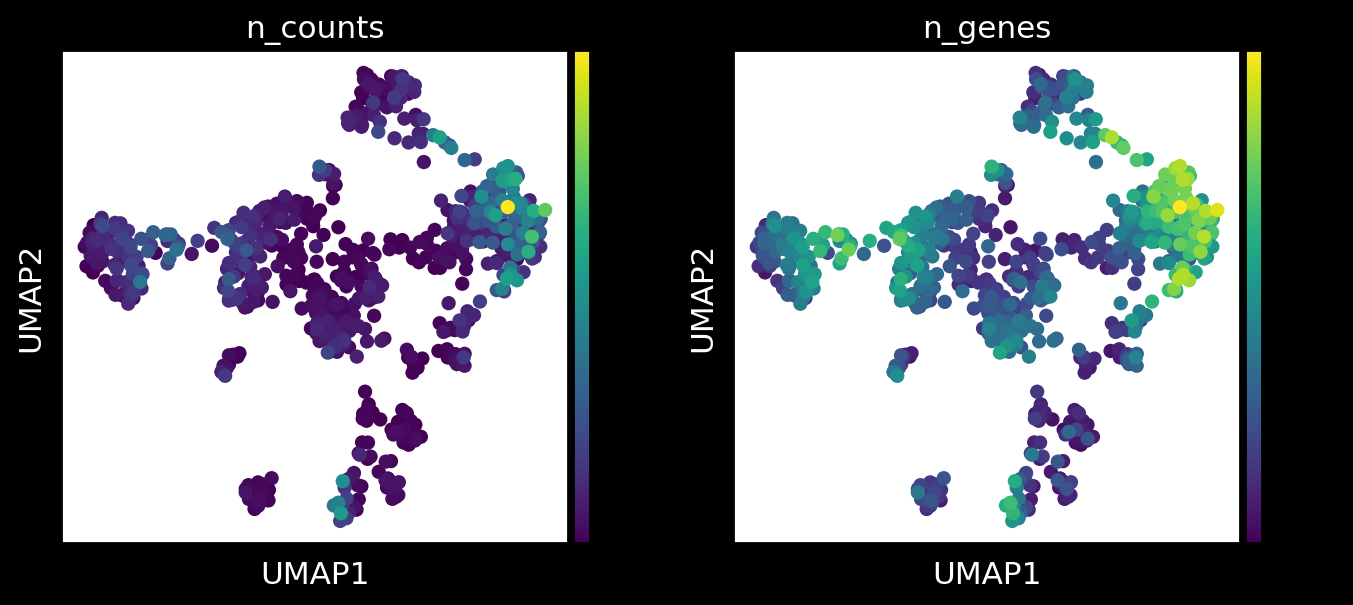

In [18]:
import scanpy as sc
sc.settings.set_figure_params(dpi=80)

# run standard analysis on the ensembled anndata
adata_ensembl = br.tl.cell_analyze(adata_ensembl)

# first check the data quality of segmented cells
sc.pl.umap(adata_ensembl, color = ['n_counts','n_genes'])

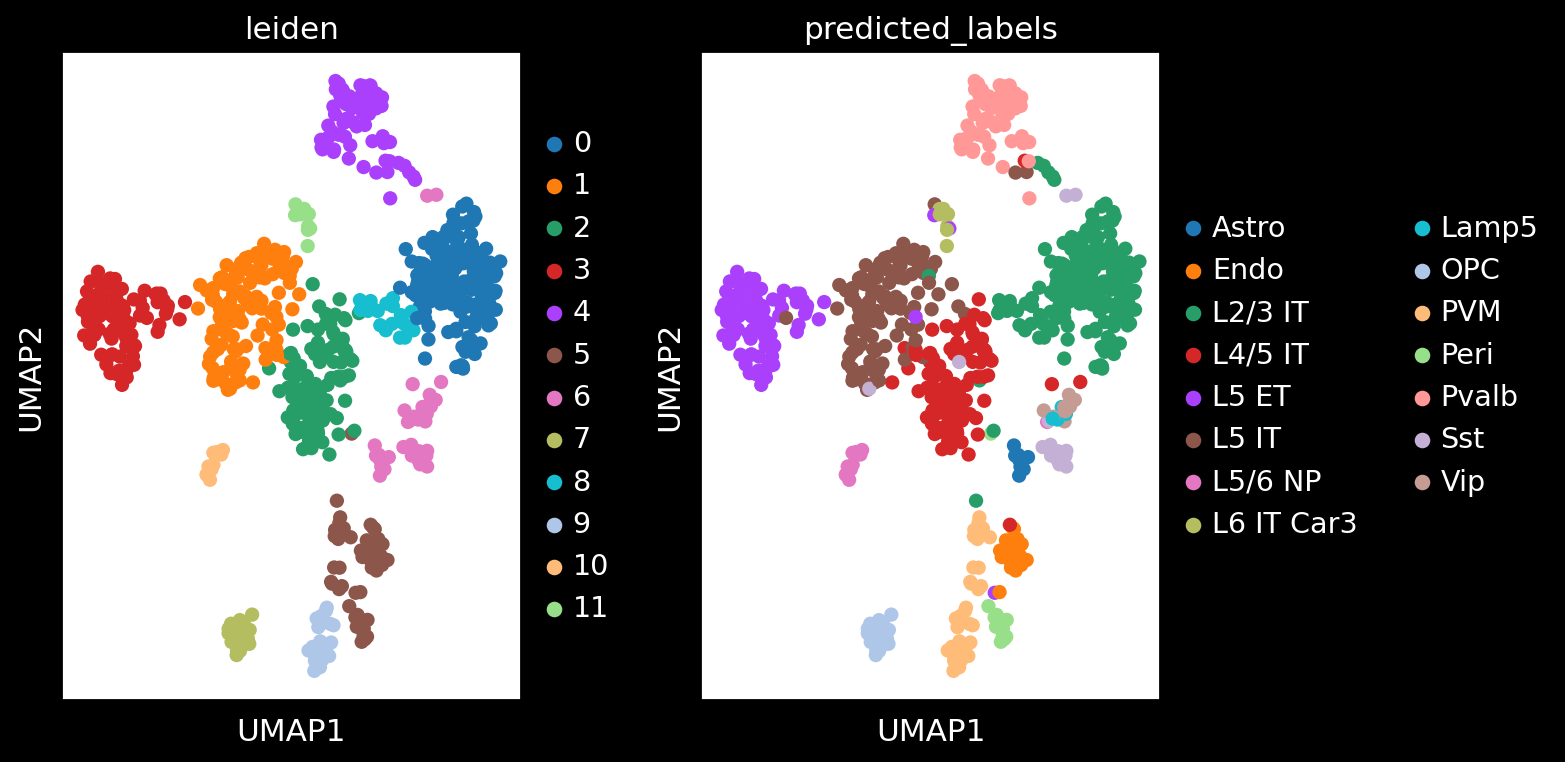

In [19]:
# plot leiden clustering and predicted labels from Bering
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0] = sc.pl.umap(adata_ensembl, color = ['leiden'], ax = axes[0], show = False)
axes[1] = sc.pl.umap(adata_ensembl, color = ['predicted_labels'], ax = axes[1], show = False)

plt.subplots_adjust(wspace = 0.5)
plt.tight_layout()
plt.show()